In [1]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import tensorflow.keras.utils as utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report,confusion_matrix

In [2]:
# read in CSV files, add column labels 

df = pd.read_csv('enviro_data.csv', names=['DTG', 'temp', 'humidity', 'baro_pressure', 'co_2', 'tvoc', 'uv_raw', 
                                           'amb_raw', 'uv_idx', 'lux','violet', 'indigo', 'blue', 'cyan', 'green', 
                                           'yellow', 'orange', 'red', 'loc_class'])

In [3]:
df.head()

,DTG,temp,humidity,baro_pressure,co_2,tvoc,uv_raw,amb_raw,uv_idx,lux,violet,indigo,blue,cyan,green,yellow,orange,red,loc_class
0,2021-08-04 10:57:52,28.568,42.925,1020.728,400,0,98,59186,4.090,47338.4,65535,65535,65535,65535,65535,65535,65535,65535,blue
1,2021-08-04 10:57:54,28.612,42.682,1020.742,400,0,99,59865,4.132,47916.8,65535,65535,65535,65535,65535,65535,65535,65535,blue
2,2021-08-04 10:57:56,28.619,42.151,1020.720,400,0,99,60124,4.216,48069.6,65535,65535,65535,65535,65535,65535,65535,65535,blue
3,2021-08-04 10:57:58,28.595,41.746,1020.713,400,0,99,59416,4.090,46434.4,65535,65535,65535,65535,65535,65535,65535,65535,blue
4,2021-08-04 10:58:00,28.629,41.451,1020.549,400,0,54,27978,2.254,23488.8,56330,65535,65535,65535,65535,65535,65535,65535,blue


In [4]:
# based on previous EDA, identify columns that are either:
# 1) not helpful (co2 -> all the same values, uv_raw and amb_raw -> just used to derive uv index and lux)
# 2) inaccruate (all of the DTG data was off)

df = df.drop(columns=['DTG', 'co_2', 'uv_raw', 'amb_raw'], axis=1)

In [5]:
df.columns

Index(['temp', 'humidity', 'baro_pressure', 'tvoc', 'uv_idx', 'lux', 'violet',
       'indigo', 'blue', 'cyan', 'green', 'yellow', 'orange', 'red',
       'loc_class'],
      dtype='object')

In [6]:
# may need this later to decode the results 

labels = df['loc_class']

In [22]:
# identify my independent and dependent variables

dataset = df.values
X = dataset[:,0:14].astype(float)
y = dataset[:,14]

In [23]:
np.unique(y, return_counts=True)

(array(['blue', 'green', 'yellow'], dtype=object), array([2331, 2334, 2398]))

In [24]:
# encode class values as integers

encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)

In [25]:
# convert integers to dummy variables (i.e. one hot encoded)

y = utils.to_categorical(encoded_y)

In [30]:
# [blue, green, yellow]
np.sum(y, axis=0) 

array([2331., 2334., 2398.], dtype=float32)

In [31]:
# model function

def my_model():
	# create model
	model = Sequential()
	model.add(Dense(28, input_dim=14, activation='relu'))
	model.add(Dense(3, activation='softmax'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model


In [32]:
# define a scaler variable so I can scale the data for better results

scaler = MinMaxScaler()

In [33]:
# train, test, split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
# fit the scaler on the training dataset only and then transform it

X_train = scaler.fit_transform(X_train)

In [35]:
# transform the test dataset to scale

X_test = scaler.transform(X_test)

In [36]:
np.sum(y_test, axis=0)

array([459., 466., 488.], dtype=float32)

In [37]:
# create my model

model = my_model()

In [40]:
# fit my model

model.fit(X_train, y_train, epochs=10, batch_size=4, verbose=1)

Epoch 1/100
1413/1413 [==============================] - 1s 516us/step - loss: 0.0517 - accuracy: 0.9839
Epoch 2/100
1413/1413 [==============================] - 1s 498us/step - loss: 0.0496 - accuracy: 0.9851
Epoch 3/100
1413/1413 [==============================] - 1s 491us/step - loss: 0.0473 - accuracy: 0.9864
Epoch 4/100
1413/1413 [==============================] - 1s 489us/step - loss: 0.0461 - accuracy: 0.9865
Epoch 5/100
1413/1413 [==============================] - 1s 495us/step - loss: 0.0462 - accuracy: 0.9851
Epoch 6/100
1413/1413 [==============================] - 1s 490us/step - loss: 0.0436 - accuracy: 0.9860
Epoch 7/100
1413/1413 [==============================] - 1s 490us/step - loss: 0.0423 - accuracy: 0.9876
Epoch 8/100
1413/1413 [==============================] - 1s 489us/step - loss: 0.0424 - accuracy: 0.9846
Epoch 9/100
1413/1413 [==============================] - 1s 494us/step - loss: 0.0402 - accuracy: 0.9865
Epoch 10/100
1413/1413 [==============================]

In [41]:
# turn my loss data into a datafram so I can graph it and see trends

loss = pd.DataFrame(model.history.history)

<AxesSubplot:>

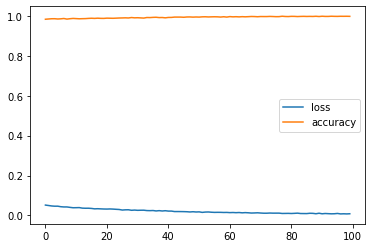

In [42]:
loss.plot()

In [43]:
# make predictions 
# predictions = model.predict_classes(X_test)

predictions = np.argmax(model.predict(X_test), axis=-1)

In [44]:
predictions

array([0, 2, 2, ..., 0, 1, 1])

In [45]:
type(predictions)

numpy.ndarray

In [46]:
y_test

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [47]:
type(y_test[0][0])

numpy.float32

In [48]:
y_test.astype(int)

array([[1, 0, 0],
       [0, 0, 1],
       [0, 0, 1],
       ...,
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0]])

In [49]:
# function so I can easily compare the true Y values with the predictions
# the true y values are in a numpy array format, so I am converting it to integers that match the predictions format

def convert_to_int(some_array):
    true_values = []
    for val in some_array:
        if val[0] == 1:
            true_values.append(0)
        elif val[1] == 1:
            true_values.append(1)
        elif val[2] == 1:
            true_values.append(2)
    
    return true_values


In [50]:
# apply my convert function to the true y values

true_y = convert_to_int(y_test)

In [51]:
# convert predictions np array into a dataframe

predictions = pd.DataFrame(predictions)

In [52]:
# reverse encoding
for pred in predictions:
    print(labels[pred])

blue


In [53]:
# convert the (modified) true y values to a dataframe

true_y = pd.DataFrame(true_y)

In [54]:
# this step makes it easier to concatenate the predictions and the true y values into one dataframe?

both = [predictions, true_y]

In [55]:
# concatenate the true y values and the predictions into one dataframe

results = pd.concat(both, axis=1)

In [56]:
results.columns

Int64Index([0, 0], dtype='int64')

In [57]:
# set the column names for the results dataframe

results.columns=['Predictions', 'True Values']

In [58]:
results.head()

,Predictions,True Values
0,0,0
1,2,2
2,2,2
3,1,1
4,2,2


In [59]:
# add a third column so I can get boolean values for each row as to whether or not the prediction matched the true value

results['Correct'] = results['Predictions'] == results['True Values']

In [60]:
results.head()

,Predictions,True Values,Correct
0,0,0,True
1,2,2,True
2,2,2,True
3,1,1,True
4,2,2,True


In [61]:
# how many the model got correct

nbr_correct = results['Correct'].sum()

In [62]:
# total number of data points

total_row = len(results)

In [63]:
# the accuracy score for my model

accuracy = nbr_correct / total_row

In [64]:
accuracy

0.9992922859164898

In [72]:
def prediction(row):
	pred = np.argmax(model.predict(row),axis=-1)
	return pred